# import packages

In [1]:
import numpy as np
import pandas as pd
#settings: 將預設顯示的row數改為500, column數改為100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

#feature matrices processing
from itertools import product #for Cartesian product
from sklearn.preprocessing import LabelEncoder #將分類型features進行index編碼

#data visualization
import seaborn as sns #for prettier plot
import matplotlib.pyplot as plt
%matplotlib inline

#tuning parameters
from xgboost import XGBRegressor 
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys #系統相關的參數跟函式
import gc #垃圾回收並解決循環引用的問題
import pickle #物件永續性管理
sys.version_info #查看此python 版本

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

# import data

In [2]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train_v2.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./input/test.csv').set_index('ID')


# feature processing

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


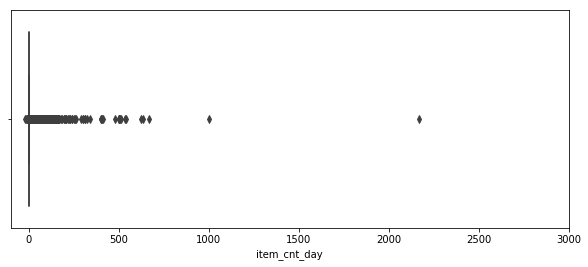

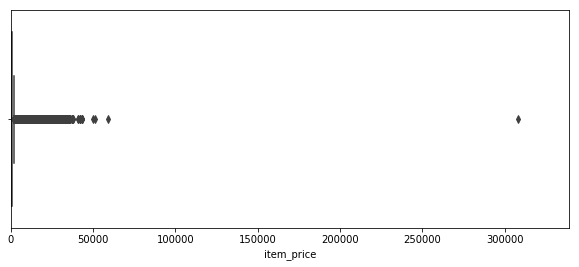

In [4]:
#observing sales data
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
print(train.item_cnt_day.min(),train.item_price.min())

-22.0 -1.0


In [6]:
#item_cnt_day<0可能是因為退貨，所以先不改
#train[train.item_cnt_day<0]

In [7]:
train[train.item_price<0] 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


發現有些異常大的值出現在item_cnt_day跟item_price中，研究一下之後決定將price>10000跟sales>1001的資料刪掉

且發現有item的price小於0，因此決定用該item在同間shop、同個月分時的中位數取代其price值

而有些item_cnt_day會小於0，可能是因為退貨，不是錯誤的值，因此不更動

In [8]:
#remove outliers
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [9]:
#replace the negative values
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [10]:
'''
neg_sales=train[train.item_cnt_day<0]
for i in neg_sales.index:
    median = train[(train.shop_id==train.iloc[i][2])&(train.item_id==train.iloc[i][3])&(train.date_block_num==train.iloc[i][1])&(train.item_cnt_day>0)].item_cnt_day.median()
    if np.isnan(median):
        train.loc[i,'item_cnt_day']= 0
    else:
        train.loc[i,'item_cnt_day']= median
    #print(median,train.iloc[i]['item_cnt_day'])
'''

"\nneg_sales=train[train.item_cnt_day<0]\nfor i in neg_sales.index:\n    median = train[(train.shop_id==train.iloc[i][2])&(train.item_id==train.iloc[i][3])&(train.date_block_num==train.iloc[i][1])&(train.item_cnt_day>0)].item_cnt_day.median()\n    if np.isnan(median):\n        train.loc[i,'item_cnt_day']= 0\n    else:\n        train.loc[i,'item_cnt_day']= median\n    #print(median,train.iloc[i]['item_cnt_day'])\n"

有一些不同的shop_id指的是同一間店，這是因為shop店名可能當初登錄寫法不同，所以這裡要找出並修正train set、test set

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
#查看shop_id有沒有重複的
import difflib
def string_similar(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).quick_ratio()

In [13]:
for i in range(len(shops)):
    for j in range(i+1,len(shops)):
        s=string_similar(shops.iloc[i]['shop_name'],shops.iloc[j]['shop_name'])
        if s>0.8:
            print(i,':',shops.iloc[i]['shop_name'],j,':',shops.iloc[j]['shop_name'])

0 : !Якутск Орджоникидзе, 56 фран 57 : Якутск Орджоникидзе, 56
1 : !Якутск ТЦ "Центральный" фран 58 : Якутск ТЦ "Центральный"
10 : Жуковский ул. Чкалова 39м? 11 : Жуковский ул. Чкалова 39м²
23 : Москва ТК "Буденовский" (пав.А2) 24 : Москва ТК "Буденовский" (пав.К7)
30 : Москва ТЦ "Перловский" 31 : Москва ТЦ "Семеновский"
38 : Омск ТЦ "Мега" 54 : Химки ТЦ "Мега"
39 : РостовНаДону ТРК "Мегацентр Горизонт" 40 : РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [14]:
#篩選出三組重複的(0,57、1,58、10,11)-->fix train, test
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [15]:
#查看train,test有沒有null,nan
print(train.isnull().any())
print(test.isnull().any())
print(train.isna().any())
print(test.isna().any())

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool
shop_id    False
item_id    False
dtype: bool
date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool
shop_id    False
item_id    False
dtype: bool


### Shops/Cats/Items preprocessing

In [16]:
#查看shop,item,cat有沒有nan
print(shops.isnull().any())
print(cats.isnull().any())
print(items.isnull().any())

shop_name    False
shop_id      False
dtype: bool
item_category_name    False
item_category_id      False
dtype: bool
item_name           False
item_id             False
item_category_id    False
dtype: bool


In [17]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [18]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [19]:
#因為地段對於sales會有影響，因此抽取建立出city並編碼成為新的feature
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#只保留shop_id跟city_code這些編碼後的名目型features
shops = shops[['shop_id','city_code']] 

In [20]:
#將item分類(提高其level，避免ovrfitting)並編碼
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
#只保留編碼後的名目型features
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [21]:
#只保留編碼後的名目型feature
items.drop(['item_name'], axis=1, inplace=True)

### Monthly sales

先查看Test data和train data的item、shop分布差異，再來決定如何處理monthly sales

In [22]:
#看test data的item分布
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [23]:
len(list(set(test.shop_id) - set(test.shop_id).intersection(set(train.shop_id)))), len(list(set(test.shop_id))), len(test)

(0, 42, 214200)

test set是34個月份的shop、item的pair組合，共有5100個items * 42個shops = 214200個pairs，其中有363個items是train set中沒有的，因此包含這些items的pairs會被predict為0。

而train set中也只記錄有賣出去或是退貨的pairs，因此the main idea是要算出monthly sales並增加每個月的pairs成為包含有各種item-shop pairs，沒紀錄過的pairs其銷售值為0。如此，train data就會跟test data相似了

In [24]:
#建立DataFrame儲存train set的每個月份的shop-item pairs
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts #看花了多少時間

20.455291986465454

接下來計算每個月的每個item-shop pairs的總銷售，並把值限制在(0,20)，這樣能讓Train target跟Test prediction更相近

並用float為item_cnt_month資料型別，如此可以避免後面加上test set會產生doqncasting的現象(因為int16如果concat NaN就會變成int64，而float16還是會是float16不變)

In [25]:
#建立新的feature表示各月各shop的各item的營收
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [26]:
ts = time.time()

#在matrix這個DataFrame增加一個feature表示每個月的各item-shop pair的銷售量(item_cnt_month)
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left') ##看看merge是長怎樣
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # 將每月銷售量的值限制在0,10之間，讓train target跟test prediction的分布相似
                                .astype(np.float16))
time.time() - ts #看花了多少時間

13.935046911239624

將test data加入matrix

In [27]:
test['date_block_num'] = 34 
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [28]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.2520103454589844

將Shops/Items/Cats features加入matrix

In [29]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

10.988888502120972

### Target lags
接下來採用shifted的概念來處理資料(看趨勢或是shifted mean等等)

In [30]:
#把時間往後 (等於是說原本的月份資料會在跟幾個月前的資料變成一起，可能就會一起計算之類的)
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i 
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left') #看會長怎樣，其他features會變一堆na?
    return df

In [31]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

80.2229814529419

接下來產生**Mean encoded features**

In [32]:
#算每個月的平均sales並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt') 
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts

27.18666124343872

In [33]:
#算每個月的每個item的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt') 
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

92.80684804916382

In [34]:
#算每個月的每個item類型的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

31.562026739120483

In [35]:
#算每個月的每個shop的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt') 
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

101.66145515441895

In [36]:
#算每個月的每個shop、item類型的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.87117576599121

In [37]:
#算每個月的shop、item大類型(type)的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt') 
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

39.124844789505005

In [38]:
#算每個月的每個shop、item更細類型(subtype)的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt') 
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.758745431900024

In [39]:
#算每個月的每個city的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt') 
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.46424913406372

In [40]:
#算每個月的每個item、city的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt') 
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

55.096829414367676

In [41]:
#算每個月的item類型的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.67027449607849

In [42]:
#算每個月的item更細類型的平均sale並lag後加入matrix
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt') 
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

45.42716026306152

計算**Trend features**

前六個月的price trend

In [43]:
ts = time.time()

#算每個item在整個時間中的平均價
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

#算每個item在每個月的平均價
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
#這裡是先lag再delta
#算lag後的item售價的差比
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

#每個row都一個delta_price_lag的值
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

#drop掉冗餘的features
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts


622.6521747112274

前1個月的shop的revenue trend

In [44]:
ts = time.time()
#算每個月的每個shop的總revenue
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
#算每個shop在整個時間中的平均月revenue
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']}) ##trian.?
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)
#這裡是先delta再lag
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

50.0029730796814

### Special features

加上每個時間是哪個月份及其共有幾天在該月分

In [45]:
matrix['month'] = matrix['date_block_num'] % 12

In [46]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

計算每個shop-item pair、每個item銷售出去的月份間距

In [47]:
ts = time.time()
#用hashtable來查找每個pair的銷售月份間距
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

2214.6370401382446

In [48]:
ts = time.time()
#用hashtable來查找每個item的銷售月份間距
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1398.1033132076263

計算item-shop、item第一次銷售出去後到該次銷售間隔的時間(月份)

In [49]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

6.492425203323364

### Final preparations

因為剛剛lag值為12，所以把前12個月的資料drop掉(包含跟這前12個月有關的columns)

In [50]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

7.6535797119140625

lag後產生許多NaN，這裡把他們fill in

In [51]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

9.34571385383606

In [52]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [53]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [54]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Prediction: xgboost

In [55]:
data = pd.read_pickle('data.pkl')

In [56]:
#選擇features
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

splitting data

In [57]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [58]:
del data
gc.collect();

In [59]:
ts = time.time()
#prediction by XGBoost Regression
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, #樹節點<300就不往下分了
    colsample_bytree=0.8, #每次構建新樹時抽取比例的features
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.12116	validation_1-rmse:1.11587
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.07796	validation_1-rmse:1.07868
[2]	validation_0-rmse:1.04131	validation_1-rmse:1.0474
[3]	validation_0-rmse:0.994496	validation_1-rmse:1.02081
[4]	validation_0-rmse:0.963761	validation_1-rmse:0.99742
[5]	validation_0-rmse:0.939131	validation_1-rmse:0.978365
[6]	validation_0-rmse:0.916276	validation_1-rmse:0.96369
[7]	validation_0-rmse:0.895088	validation_1-rmse:0.951517
[8]	validation_0-rmse:0.878678	validation_1-rmse:0.940988
[9]	validation_0-rmse:0.865852	validation_1-rmse:0.932848
[10]	validation_0-rmse:0.853602	validation_1-rmse:0.92614
[11]	validation_0-rmse:0.843152	validation_1-rmse:0.921396
[12]	validation_0-rmse:0.833813	validation_1-rmse:0.916814
[13]	validation_0-rmse:0.82677	validation_1-rmse:0.913193
[14]	validation_0-rmse:0.81953	valida

5082.3326914310455

In [60]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

#儲存最終predict的結果為submission
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)